1.5.3
                     wt2m  wt4m  wt6m  wt7m  wt9m  wt11m  wspd  wdir1  do8m  \
x_date                                                                        
2011-05-05 12:00:00   NaN   NaN   NaN   NaN   NaN    NaN  14.2  119.0   NaN   
2011-05-06 12:00:00   NaN   NaN   NaN   NaN   NaN    NaN   9.9  173.0   NaN   
2011-05-07 12:00:00   NaN   NaN   NaN   NaN   NaN    NaN   9.7  188.0   NaN   
2011-05-08 12:00:00   NaN   NaN   NaN   NaN   NaN    NaN   7.2    3.0   NaN   
2011-05-09 12:00:00   NaN   NaN   NaN   NaN   NaN    NaN  13.8   32.0   NaN   

                     do11m  
x_date                      
2011-05-05 12:00:00    NaN  
2011-05-06 12:00:00    NaN  
2011-05-07 12:00:00    NaN  
2011-05-08 12:00:00    NaN  
2011-05-09 12:00:00    NaN  
Most frequent wind direction on days with large changes in do8m: 204.0
Most frequent wind direction on days with large changes in do11m: 255.0
The 65th percentile of wind speed is: 11.7 (Knots)


C:\Users\cbeau\AppData\Local\Temp\ipykernel_14844\4129376053.py:120: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cbeau\AppData\Local\Temp\ipykernel_14844\4129376053.py:121: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cbeau\AppData\Local\Temp\ipykernel_14844\4129376053.py:124: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

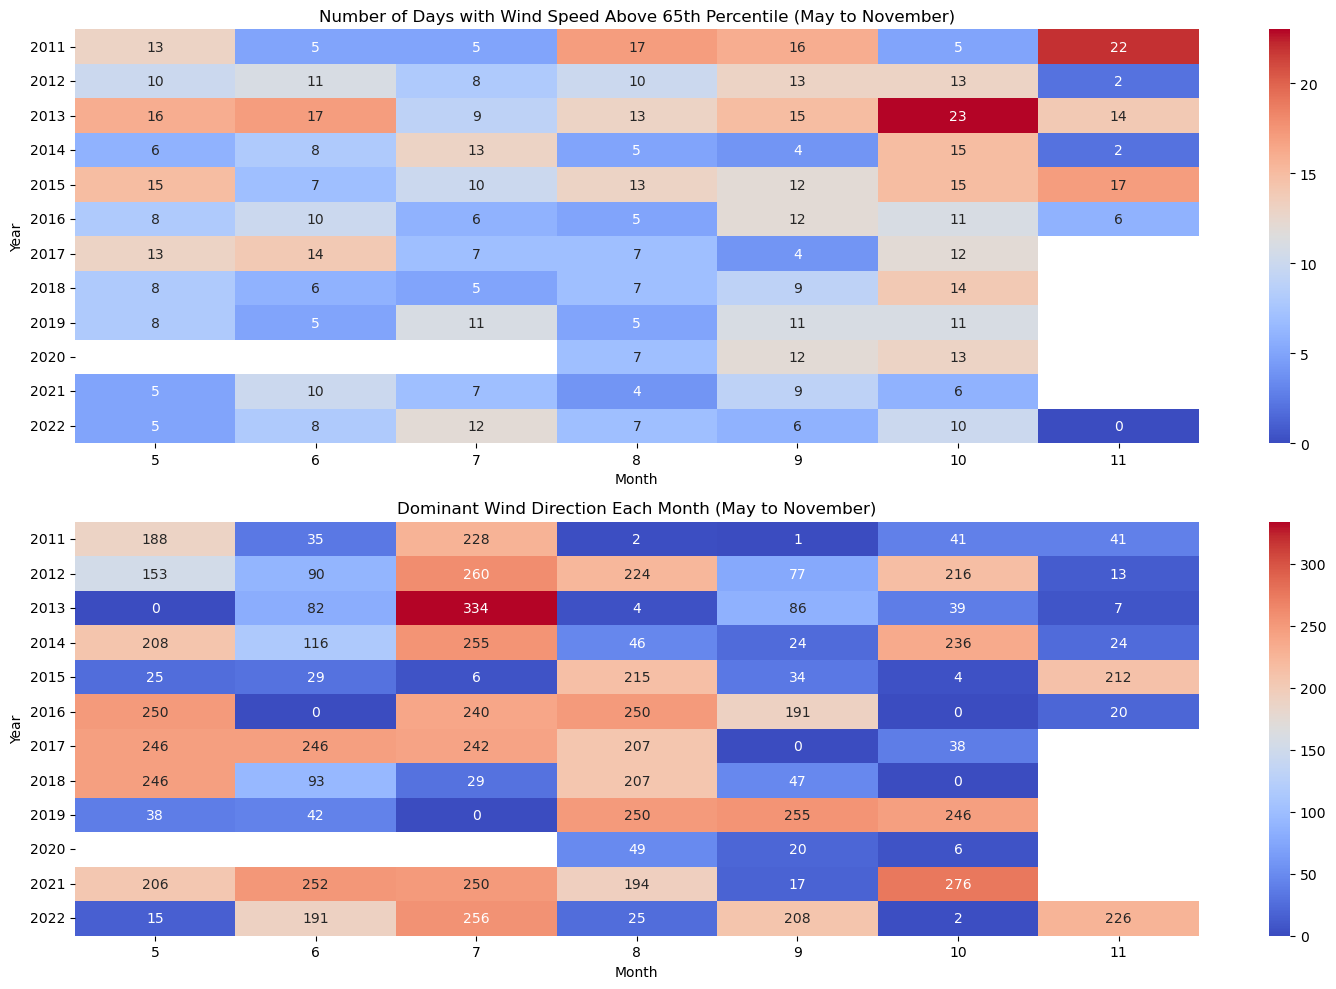

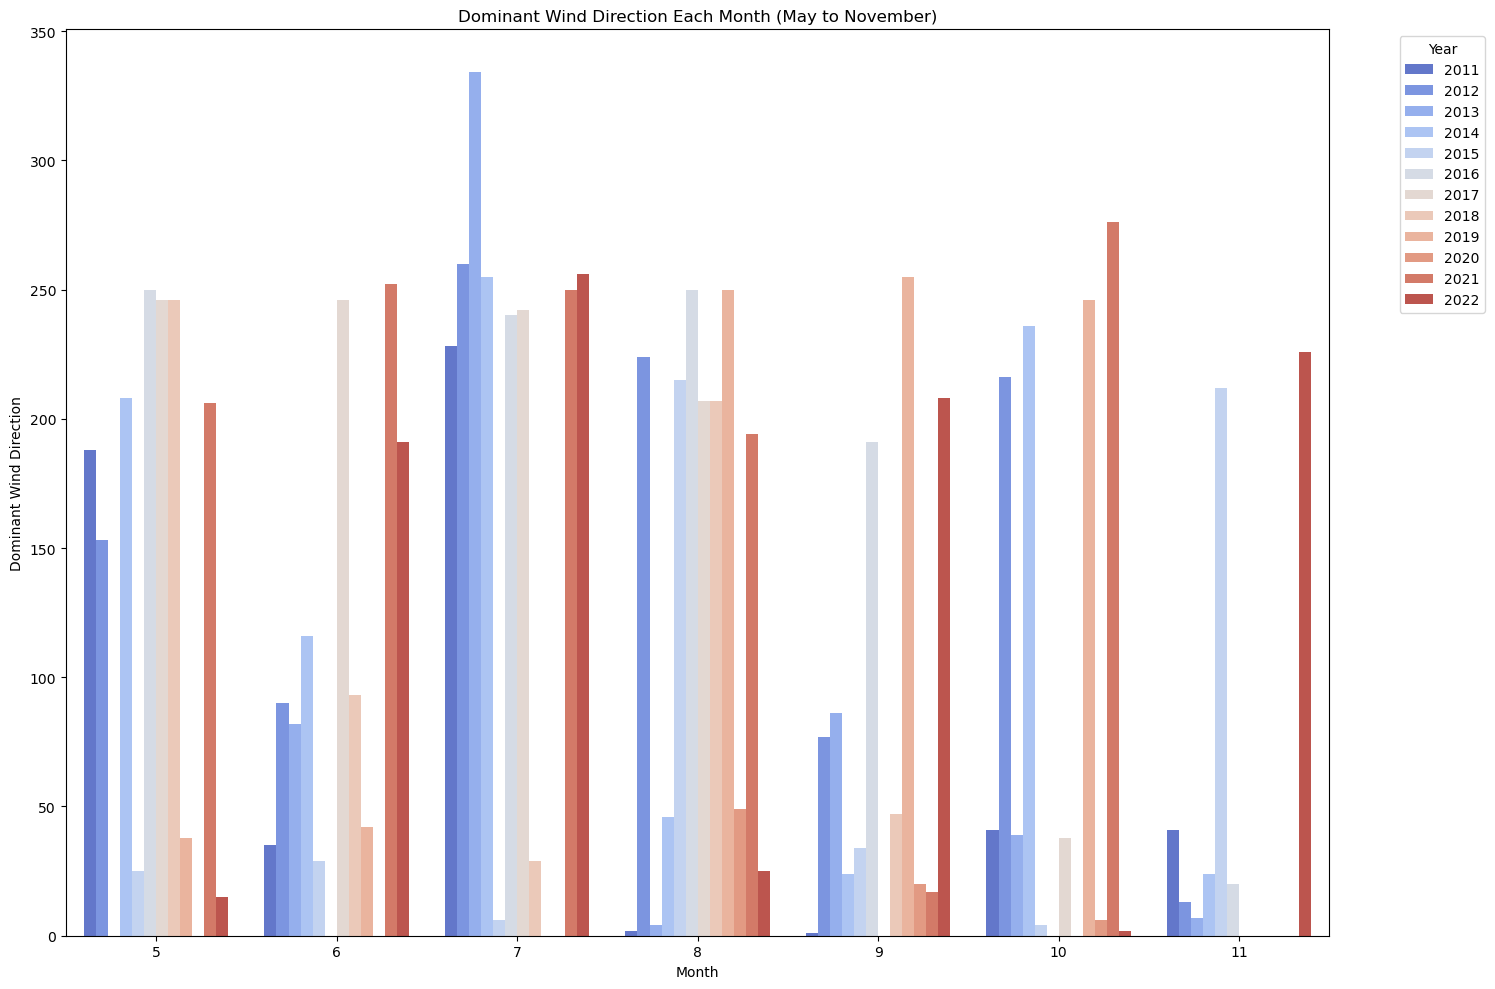

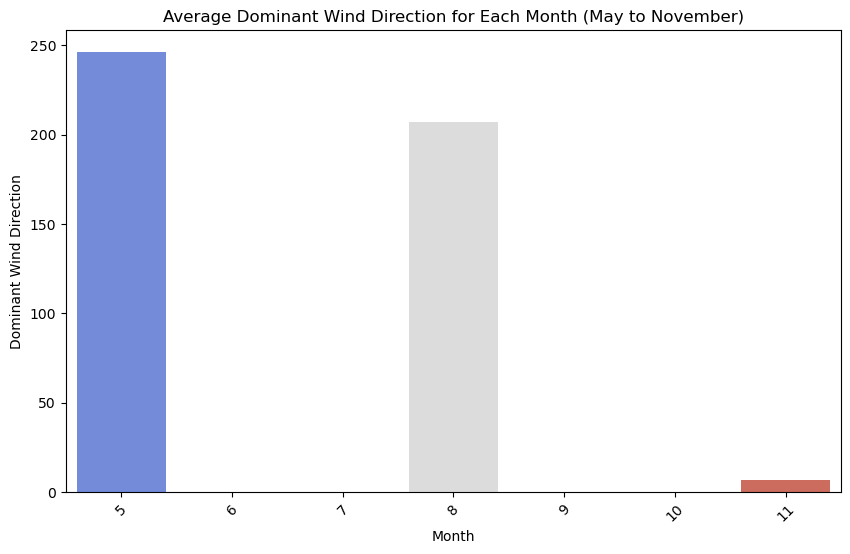

A significant correlation with the sine component suggests a relationship with the north-south direction.
A significant correlation with the cosine component suggests a relationship with the east-west direction.
Correlation between wind speed and sine component of wind direction: -0.23996764902753914, p-value: 1.9700245399211658e-31
Correlation between wind speed and cosine component of wind direction: -0.27514961977650576, p-value: 3.6581662608152213e-41
Correlation between sine of wind direction and DO at 8m: PearsonRResult(statistic=0.04358368010856124, pvalue=0.05339903315972972)
Correlation between cosine of wind direction and DO at 8m: PearsonRResult(statistic=-0.0395658806473296, pvalue=0.07952314977610155)
Correlation between sine of wind direction and DO at 11m: PearsonRResult(statistic=-0.004926128464898521, pvalue=0.8272503990288967)
Correlation between cosine of wind direction and DO at 11m: PearsonRResult(statistic=-0.030862725889865182, pvalue=0.1714535974605408)


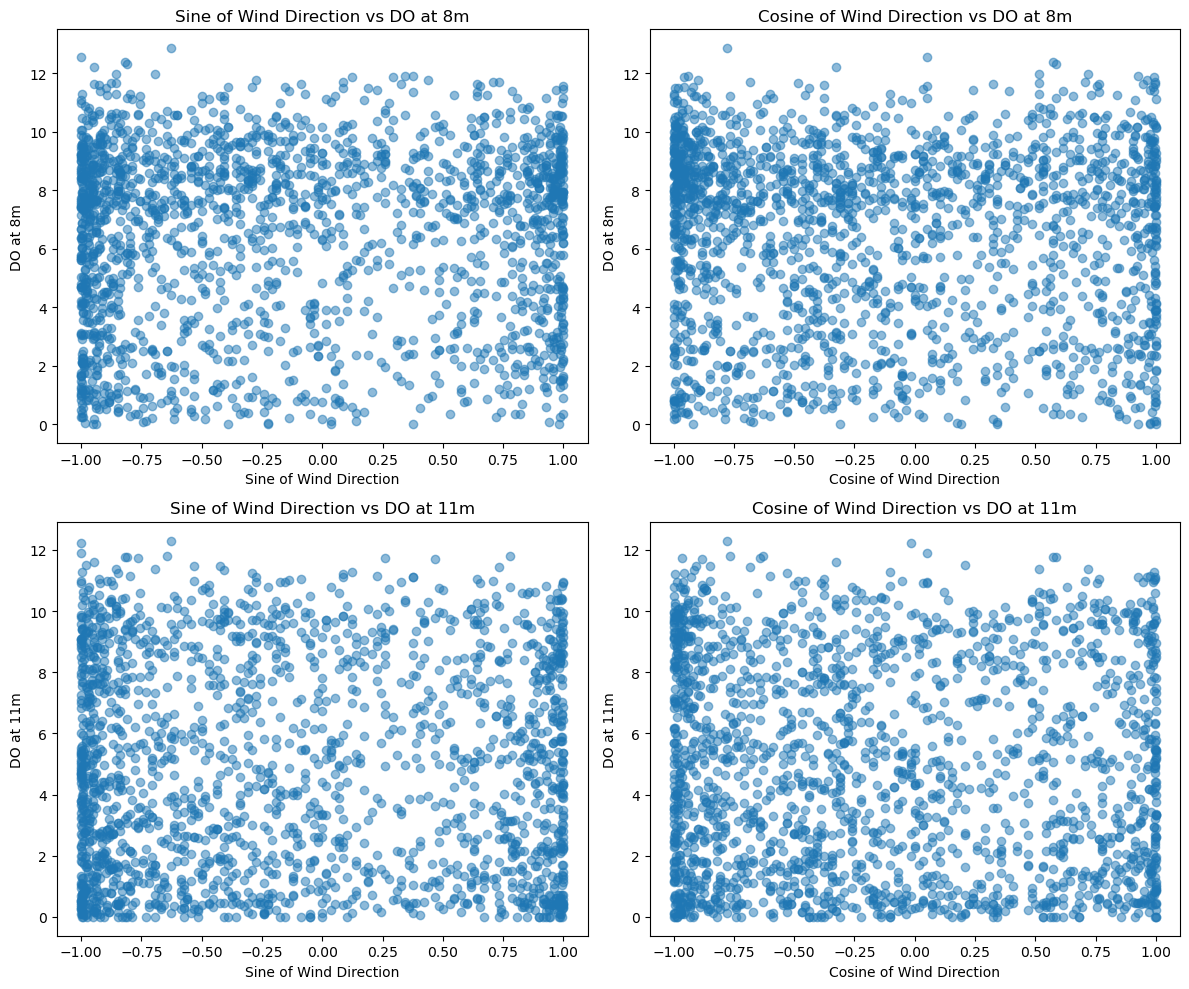

Correlation between wind speed and DO at 8m: 0.22281426158225107, p-value: 1.5768433102962225e-23
Correlation between wind speed and DO at 11m: 0.21745466683781056, p-value: 1.84167724460243e-22


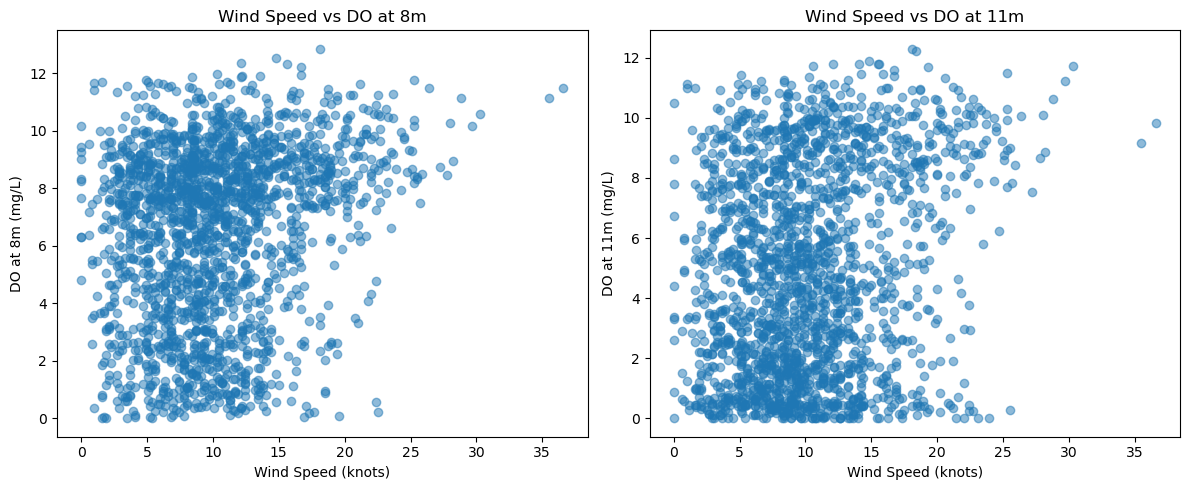

In [30]:
# Really need these
import pandas as pd 
import numpy as np
from numpy import *
from scipy.stats import skew
from statsmodels.tsa.seasonal import STL

# Handy for debugging
import gc
import time
import warnings
import os

# Date stuff
from datetime import datetime
from datetime import timedelta

# Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns

# Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Performance measures
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from calendar import month_abbr
import scipy.stats as stats
###################################################################################################################
# Load the data from the csv file,dont forget the extra backslahses
Path = "C:\\Users\\cbeau\\Downloads\\MUSKEGON_LAKE\\MUSKEGON_LAKE_ DATA.xlsx"
ML= pd.read_excel(Path)

# Ensure you have an up-to-date version of pandas
print(pd.__version__)

# Convert date columns to datetime
date_columns = ['x_date']  # Replace with your date column names
for date_column in date_columns:
    ML[date_column] = pd.to_datetime(ML[date_column])

# Convert other columns to numeric
for column in ML.columns:
    if column not in date_columns:
        ML[column] = pd.to_numeric(ML[column], errors='coerce')

#########################################################################################

# Select the columns for the new dataset
selected_columns = [
    'wt2m', 'wt4m', 'wt6m', 'wt7m', 'wt9m', 'wt11m', 
    'wspd', 'wdir1', 'do8m', 'do11m','x_date'
]

# Create the new dataset
ml = ML[selected_columns].copy()

ml.set_index('x_date', inplace=True)

# Filter data to include only between 5/1 and 11/1 each year
# and exclude data after 11/1/2022
ml_filtered = ml[(ml.index.month >= 5) & (ml.index.month <= 11) & (ml.index < '2022-11-02')]


# Display the first few rows of the modified dataset
print(ml.head())


################################################################################################################

#######################################################################################################
# Calculate 7-day rolling average for wspd
ml['wspd_7d_avg'] = ml['wspd'].rolling(window=7, min_periods=1).mean()

# Calculate daily changes in do8m and do11m
ml['do8m_change'] = ml['do8m'].diff()
ml['do11m_change'] = ml['do11m'].diff()

# Identify days with the largest changes in DO levels
threshold_do8m = ml['do8m_change'].quantile(0.95)
threshold_do11m = ml['do11m_change'].quantile(0.95)

# Extract corresponding wind direction on those days
large_changes_do8m = ml[ml['do8m_change'] >= threshold_do8m]
large_changes_do11m = ml[ml['do11m_change'] >= threshold_do11m]

# Get the most frequent wind direction on days with large DO changes
most_frequent_wdir_do8m = large_changes_do8m['wdir1'].mode()[0]
most_frequent_wdir_do11m = large_changes_do11m['wdir1'].mode()[0]

print(f"Most frequent wind direction on days with large changes in do8m: {most_frequent_wdir_do8m}")
print(f"Most frequent wind direction on days with large changes in do11m: {most_frequent_wdir_do11m}")
####################################################################################################


# Calculate the 65th percentile of wspd
wspd_65th_percentile = ml['wspd'].quantile(0.65)
print(f"The 65th percentile of wind speed is: {wspd_65th_percentile} (Knots)")


# Create a column for year and month
ml_filtered['year'] = ml_filtered.index.year
ml_filtered['month'] = ml_filtered.index.month

# Determine if wind speed is above the 65th percentile
ml_filtered['above_65th'] = ml_filtered['wspd'] > wspd_65th_percentile

# Pivot table for wind speed count above 65th percentile
pivot_speed = ml_filtered.pivot_table(index='year', columns='month', values='above_65th', aggfunc='sum')

# Pivot table for dominant wind direction
pivot_direction = ml_filtered.pivot_table(index='year', columns='month', values='wdir1', aggfunc=lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Creating the heatmaps
plt.figure(figsize=(15, 10))

# Wind Speed Heatmap
plt.subplot(2, 1, 1)
sns.heatmap(pivot_speed, annot=True, cmap='coolwarm', fmt='g')
plt.title('Number of Days with Wind Speed Above 65th Percentile (May to November)')
plt.ylabel('Year')
plt.xlabel('Month')

# Wind Direction Heatmap
plt.subplot(2, 1, 2)
sns.heatmap(pivot_direction, annot=True, cmap='coolwarm', fmt='g')
plt.title('Dominant Wind Direction Each Month (May to November)')
plt.ylabel('Year')
plt.xlabel('Month')

plt.tight_layout()
plt.show()

# Flatten the pivot table for easier plotting
flat_data = pivot_direction.reset_index().melt(id_vars='year', var_name='month', value_name='dominant_wind_direction')
flat_data.dropna(inplace=True)  # Drop any NaN values

# Plotting the bar chart for dominant wind direction
plt.figure(figsize=(15, 10))

sns.barplot(x='month', y='dominant_wind_direction', hue='year', data=flat_data, palette='coolwarm')
plt.title('Dominant Wind Direction Each Month (May to November)')
plt.ylabel('Dominant Wind Direction')
plt.xlabel('Month')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Calculate the mode (most frequent value) of wind direction for each month across all years
average_dominant_direction = pivot_direction.apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan, axis=0)

# Drop any NaN values (if there are months with no dominant direction)
average_dominant_direction.dropna(inplace=True)

# Creating the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=average_dominant_direction.index, y=average_dominant_direction.values, palette='coolwarm')
plt.title('Average Dominant Wind Direction for Each Month (May to November)')
plt.xlabel('Month')
plt.ylabel('Dominant Wind Direction')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()
############################################################################################ 

#wind direction is a circular variable, need to make linear breaking it down into sin & cos

# Ensure 'wdir1' is in radians for sine and cosine calculations
wdir_radians = np.radians(ml['wdir1'])

# Decompose wind direction into sine and cosine components
sin_wdir = np.sin(wdir_radians)
cos_wdir = np.cos(wdir_radians)

# Remove or impute NaNs and infinite values
clean_indices = np.isfinite(ml['wspd']) & np.isfinite(sin_wdir) & np.isfinite(cos_wdir)
wspd_clean = ml['wspd'][clean_indices]
sin_wdir_clean = sin_wdir[clean_indices]
cos_wdir_clean = cos_wdir[clean_indices]

# Correlate these components with wind speed
correlation_sin = stats.pearsonr(wspd_clean, sin_wdir_clean)
correlation_cos = stats.pearsonr(wspd_clean, cos_wdir_clean)

print('A significant correlation with the sine component suggests a relationship with the north-south direction.')
print('A significant correlation with the cosine component suggests a relationship with the east-west direction.')
print(f"Correlation between wind speed and sine component of wind direction: {correlation_sin[0]}, p-value: {correlation_sin[1]}")
print(f"Correlation between wind speed and cosine component of wind direction: {correlation_cos[0]}, p-value: {correlation_cos[1]}")
#################################################################################################################################################################
# Ensure 'wdir1' is in radians for sine and cosine calculations
wdir_radians = np.radians(ml['wdir1'])

# Decompose wind direction into sine and cosine components
sin_wdir = np.sin(wdir_radians)
cos_wdir = np.cos(wdir_radians)

# Clean the data by removing NaNs for wind direction and dissolved oxygen levels
clean_indices = np.isfinite(sin_wdir) & np.isfinite(cos_wdir) & np.isfinite(ml['do8m']) & np.isfinite(ml['do11m'])
sin_wdir_clean = sin_wdir[clean_indices]
cos_wdir_clean = cos_wdir[clean_indices]
do8m_clean = ml['do8m'][clean_indices]
do11m_clean = ml['do11m'][clean_indices]

# Correlation analysis
correlation_sin_do8m = stats.pearsonr(sin_wdir_clean, do8m_clean)
correlation_cos_do8m = stats.pearsonr(cos_wdir_clean, do8m_clean)
correlation_sin_do11m = stats.pearsonr(sin_wdir_clean, do11m_clean)
correlation_cos_do11m = stats.pearsonr(cos_wdir_clean, do11m_clean)

# Print out the correlation results
print("Correlation between sine of wind direction and DO at 8m:", correlation_sin_do8m)
print("Correlation between cosine of wind direction and DO at 8m:", correlation_cos_do8m)
print("Correlation between sine of wind direction and DO at 11m:", correlation_sin_do11m)
print("Correlation between cosine of wind direction and DO at 11m:", correlation_cos_do11m)

# Visualization
plt.figure(figsize=(12, 10))

# Scatter plot for wind direction sine component vs DO at 8m
plt.subplot(2, 2, 1)
plt.scatter(sin_wdir_clean, do8m_clean, alpha=0.5)
plt.title('Sine of Wind Direction vs DO at 8m')
plt.xlabel('Sine of Wind Direction')
plt.ylabel('DO at 8m')

# Scatter plot for wind direction cosine component vs DO at 8m
plt.subplot(2, 2, 2)
plt.scatter(cos_wdir_clean, do8m_clean, alpha=0.5)
plt.title('Cosine of Wind Direction vs DO at 8m')
plt.xlabel('Cosine of Wind Direction')
plt.ylabel('DO at 8m')

# Scatter plot for wind direction sine component vs DO at 11m
plt.subplot(2, 2, 3)
plt.scatter(sin_wdir_clean, do11m_clean, alpha=0.5)
plt.title('Sine of Wind Direction vs DO at 11m')
plt.xlabel('Sine of Wind Direction')
plt.ylabel('DO at 11m')

# Scatter plot for wind direction cosine component vs DO at 11m
plt.subplot(2, 2, 4)
plt.scatter(cos_wdir_clean, do11m_clean, alpha=0.5)
plt.title('Cosine of Wind Direction vs DO at 11m')
plt.xlabel('Cosine of Wind Direction')
plt.ylabel('DO at 11m')

plt.tight_layout()
plt.show()


######################################################################################################################
# Clean the data by removing NaNs
clean_data = ml.dropna(subset=['wspd', 'do8m', 'do11m'])

# Calculate the correlation coefficients
correlation_wspd_do8m = stats.pearsonr(clean_data['wspd'], clean_data['do8m'])
correlation_wspd_do11m = stats.pearsonr(clean_data['wspd'], clean_data['do11m'])


print(f"Correlation between wind speed and DO at 8m: {correlation_wspd_do8m[0]}, p-value: {correlation_wspd_do8m[1]}")
print(f"Correlation between wind speed and DO at 11m: {correlation_wspd_do11m[0]}, p-value: {correlation_wspd_do11m[1]}")

# Visualize the correlations
plt.figure(figsize=(12, 5))

# Wind Speed vs DO at 8m
plt.subplot(1, 2, 1)
plt.scatter(clean_data['wspd'], clean_data['do8m'], alpha=0.5)
plt.title('Wind Speed vs DO at 8m')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('DO at 8m (mg/L)')

# Wind Speed vs DO at 11m
plt.subplot(1, 2, 2)
plt.scatter(clean_data['wspd'], clean_data['do11m'], alpha=0.5)
plt.title('Wind Speed vs DO at 11m')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('DO at 11m (mg/L)')

plt.tight_layout()
plt.show()

                 wt2m       wt4m       wt6m       wt7m       wt9m      wt11m  \
2011-05-08  66.735762  66.469286  66.082190  64.672714  59.035571  58.053143   
2011-05-15  58.666286  58.527714  58.321429  57.275143  56.294286  62.538857   
2011-05-22  70.067571  69.690095  68.969190  67.911857  65.102905  63.285476   
2011-05-29  60.990000  60.890000  60.875000  60.835000  60.775000  60.452571   
2011-06-05  65.695714  65.215714  64.975714  64.468571  63.547143  60.975857   

                 wspd       wdir1      do8m     do11m  
2011-05-08  10.250000  120.750000  6.053143  3.924143  
2011-05-15  12.700000  208.000000  9.377571  5.638000  
2011-05-22  10.642857  180.000000  7.413905  4.226286  
2011-05-29  14.528571  169.714286  8.510000  8.240000  
2011-06-05  12.800000  129.285714  8.410000  7.771429  
Number of NaN values in each column after KNN imputation:
 wt2m     0
wt4m     0
wt6m     0
wt7m     0
wt9m     0
wt11m    0
wspd     0
wdir1    0
do8m     0
do11m    0
dtype: int64


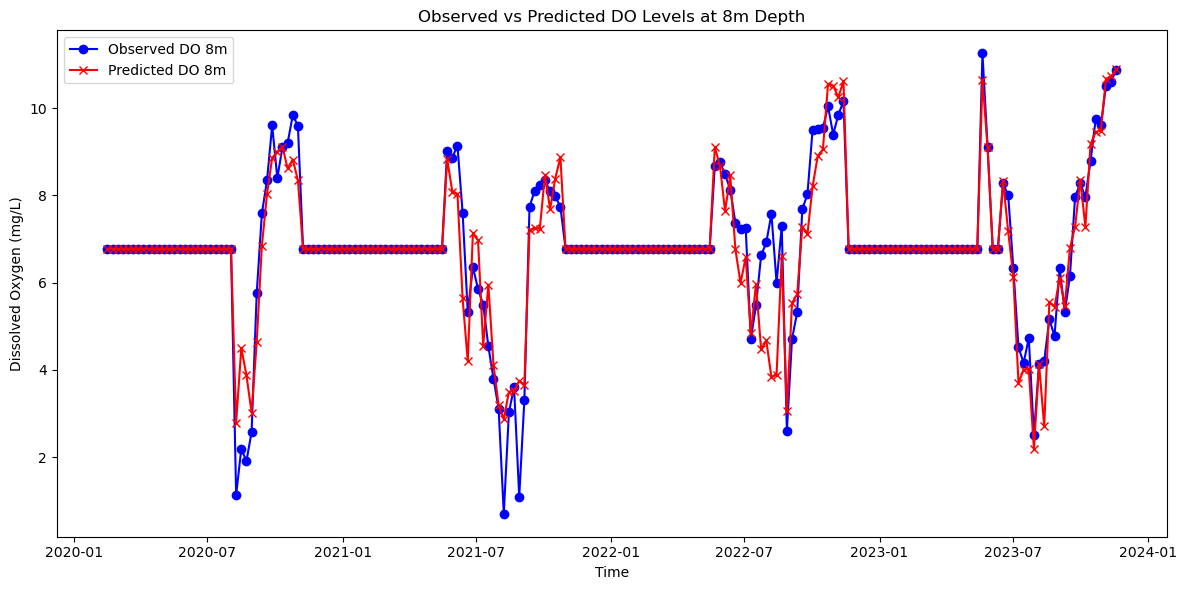

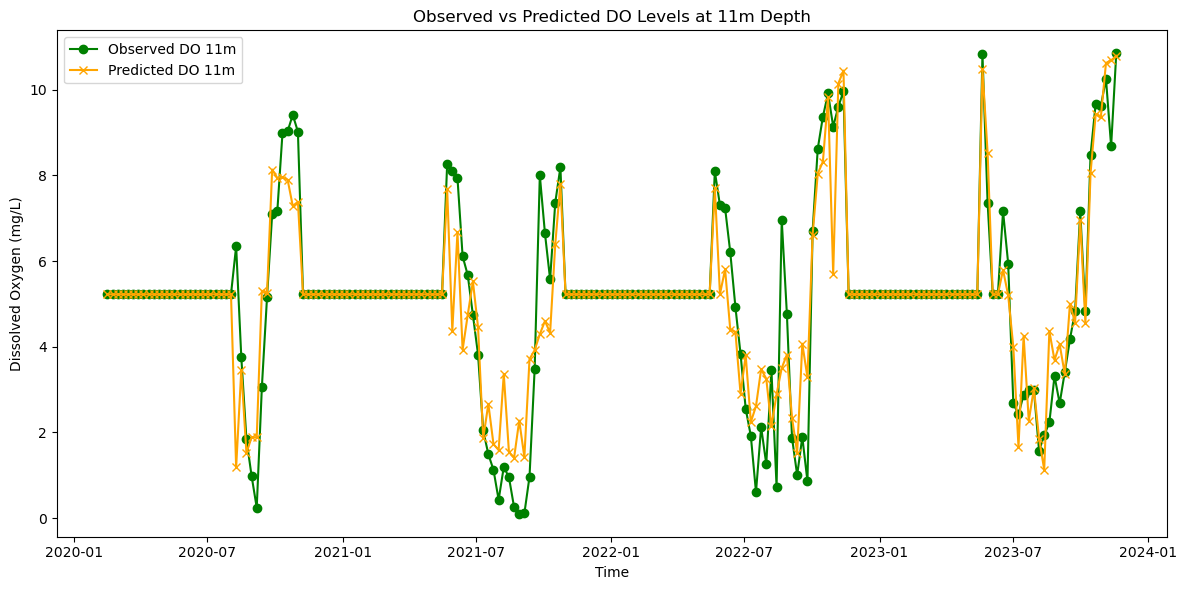

Evaluation Metrics for 'do8m':
R-squared: 0.84
Mean Absolute Error (MAE): 0.34
Mean Squared Error (MSE): 0.46
Root Mean Squared Error (RMSE): 0.68

Evaluation Metrics for 'do11m':
R-squared: 0.78
Mean Absolute Error (MAE): 0.52
Mean Squared Error (MSE): 1.02
Root Mean Squared Error (RMSE): 1.01
Peirce Skill Score (PSS) for 'do8m' with wind: 0.8244147157190636
Peirce Skill Score (PSS) for 'do11m' with wind: 0.8245222929936306


In [29]:

# Select the columns for the new dataset
selected_columns = [
    'wt2m', 'wt4m', 'wt6m', 'wt7m', 'wt9m', 'wt11m', 
    'wspd', 'wdir1', 'do8m', 'do11m','x_date'
]

# We don't need to explicitly exclude 'x_date' as it's the index and not a column
# Create the new dataset
ml = ML[selected_columns].copy()

ml.set_index('x_date', inplace=True)

# Filter data to include only between 5/1 and 11/1 each year
# and exclude data after 11/1/2022
ml_filtered = ml[(ml.index.month >= 5) & (ml.index.month <= 11) & (ml.index < '2022-11-02')]
#Evident is the disocnitunity in the data
# Make the time series continuous
# Set frequency to daily and reindex to fill missing dates with NaNs
ml = ml.asfreq('D')
ml = ml.reindex(pd.date_range(start=ml.index.min(), end=ml.index.max(), freq='D'))

# Resample the data to get weekly averages
# 'W' stands for weekly frequency
ml_weekly = ml.resample('W').mean()

# Create an instance of KNNImputer
# n_neighbors can be adjusted based on your dataset
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputation
ml_weekly_imputed = imputer.fit_transform(ml_weekly)

# Convert the imputed data back to a DataFrame
ml_weekly_imputed_df = pd.DataFrame(ml_weekly_imputed, columns=ml_weekly.columns, index=ml_weekly.index)

# Display the first few rows of the imputed dataset
print(ml_weekly_imputed_df.head())

# Check for remaining NaNs
nan_counts_after_imputation = ml_weekly_imputed_df.isna().sum()
print("Number of NaN values in each column after KNN imputation:\n", nan_counts_after_imputation)
##########################################################################################################
# Features (excluding 'do8m' and 'do11m')
feature_columns = [col for col in ml_weekly_imputed_df.columns if col not in ['do8m', 'do11m']]
X = ml_weekly_imputed_df[feature_columns]

# Target variables
y_do8m = ml_weekly_imputed_df['do8m']
y_do11m = ml_weekly_imputed_df['do11m']
################################################################################################
#70% of the data for training and 30% for testing
# Calculate the index to split the data
split_index = int(len(ml_weekly_imputed_df) * 0.7)

# Temporal split for the features
X_train = ml_weekly_imputed_df[feature_columns][:split_index]
X_test = ml_weekly_imputed_df[feature_columns][split_index:]

# Temporal split for 'do8m'
y_train_do8m = ml_weekly_imputed_df['do8m'][:split_index]
y_test_do8m = ml_weekly_imputed_df['do8m'][split_index:]
dates_8m = y_test_do8m.index  # Test dates for 'do8m'

# Temporal split for 'do11m'
y_train_do11m = ml_weekly_imputed_df['do11m'][:split_index]
y_test_do11m = ml_weekly_imputed_df['do11m'][split_index:]
dates_11m = y_test_do11m.index  # Test dates for 'do11m'
#######################################################################################################
#Training the Random Forest Models
# Train the model for 'do8m'
rf_do8m = RandomForestRegressor(n_estimators=100, random_state=42)
rf_do8m.fit(X_train, y_train_do8m)

# Train the model for 'do11m'
rf_do11m = RandomForestRegressor(n_estimators=100, random_state=42)
rf_do11m.fit(X_train, y_train_do11m)
#################################################################################################
# Make predictions for 'do8m'
y_pred_do8m = rf_do8m.predict(X_test)

# Make predictions for 'do11m'
y_pred_do11m = rf_do11m.predict(X_test)

####################################################################################
# Plotting the results for 'do8m'
plt.figure(figsize=(12, 6))
plt.plot(dates_8m, y_test_do8m, color='blue', label='Observed DO 8m', marker='o')
plt.plot(dates_8m, y_pred_do8m, color='red', label='Predicted DO 8m', marker='x')
plt.title('Observed vs Predicted DO Levels at 8m Depth')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()

plt.tight_layout()

# Plotting the results for 'do11m'
plt.figure(figsize=(12, 6))
plt.plot(dates_11m, y_test_do11m, color='green', label='Observed DO 11m', marker='o')
plt.plot(dates_11m, y_pred_do11m, color='orange', label='Predicted DO 11m', marker='x')
plt.title('Observed vs Predicted DO Levels at 11m Depth')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()

plt.tight_layout()
plt.show()

###########################################################################################
# For 'do8m'
r2_do8m = r2_score(y_test_do8m, y_pred_do8m)
mae_do8m = mean_absolute_error(y_test_do8m, y_pred_do8m)
mse_do8m = mean_squared_error(y_test_do8m, y_pred_do8m)
rmse_do8m = mean_squared_error(y_test_do8m, y_pred_do8m, squared=False)

# For 'do11m'
r2_do11m = r2_score(y_test_do11m, y_pred_do11m)
mae_do11m = mean_absolute_error(y_test_do11m, y_pred_do11m)
mse_do11m = mean_squared_error(y_test_do11m, y_pred_do11m)
rmse_do11m = mean_squared_error(y_test_do11m, y_pred_do11m, squared=False)
print(f"Evaluation Metrics for 'do8m':")
print(f"R-squared: {r2_do8m:.2f}")
print(f"Mean Absolute Error (MAE): {mae_do8m:.2f}")
print(f"Mean Squared Error (MSE): {mse_do8m:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_do8m:.2f}\n")

print(f"Evaluation Metrics for 'do11m':")
print(f"R-squared: {r2_do11m:.2f}")
print(f"Mean Absolute Error (MAE): {mae_do11m:.2f}")
print(f"Mean Squared Error (MSE): {mse_do11m:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_do11m:.2f}")
####################################################################################
#Pierce Skill Score
#Define the Threshold and Binarize the Predicted and Actual Values
#PSS=TPR−FPR
# Define the threshold
threshold = 4

# Binarize the predicted and actual values based on the threshold
# low DO (<= 4 mg/L) is represented by 1, normal/high DO (> 4 mg/L) is represented by 0
y_test_do8m_binarized = (y_test_do8m <= threshold).astype(int)
y_pred_do8m_binarized = (y_pred_do8m <= threshold).astype(int)

y_test_do11m_binarized = (y_test_do11m <= threshold).astype(int)
y_pred_do11m_binarized = (y_pred_do11m <= threshold).astype(int)

#Calculate the Confusion Matrix, TPR, FPR, and PSS

# For 'do8m'
tn_8m, fp_8m, fn_8m, tp_8m = confusion_matrix(y_test_do8m_binarized, y_pred_do8m_binarized).ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for 'do8m'
tpr_8m = tp_8m / (tp_8m + fn_8m)
fpr_8m = fp_8m / (fp_8m + tn_8m)

# Calculate Peirce Skill Score (PSS) for 'do8m'
pss_8m = tpr_8m - fpr_8m

# For 'do11m'
tn_11m, fp_11m, fn_11m, tp_11m = confusion_matrix(y_test_do11m_binarized, y_pred_do11m_binarized).ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for 'do11m'
tpr_11m = tp_11m / (tp_11m + fn_11m)
fpr_11m = fp_11m / (fp_11m + tn_11m)

# Calculate Peirce Skill Score (PSS) for 'do11m'
pss_11m = tpr_11m - fpr_11m

print(f"Peirce Skill Score (PSS) for 'do8m' with wind: {pss_8m}")
print(f"Peirce Skill Score (PSS) for 'do11m' with wind: {pss_11m}")

                 wt2m       wt4m       wt6m       wt7m       wt9m      wt11m  \
2011-05-08  70.483619  70.047790  68.564057  64.643105  59.166886  59.482629   
2011-05-15  67.962738  67.679310  67.274381  65.993286  64.029214  59.653810   
2011-05-22  74.439571  74.116714  72.271095  65.867190  60.970857  61.411429   
2011-05-29  60.990000  60.890000  60.875000  60.835000  60.775000  59.898000   
2011-06-05  65.695714  65.215714  64.975714  64.468571  63.547143  62.920743   

                 wspd      do8m     do11m  
2011-05-08  10.250000  6.948810  6.266619  
2011-05-15  12.700000  7.517810  5.342238  
2011-05-22  10.642857  2.998429  3.410190  
2011-05-29  14.528571  8.510000  8.240000  
2011-06-05  12.800000  8.410000  7.771429  
Number of NaN values in each column after KNN imputation:
 wt2m     0
wt4m     0
wt6m     0
wt7m     0
wt9m     0
wt11m    0
wspd     0
do8m     0
do11m    0
dtype: int64


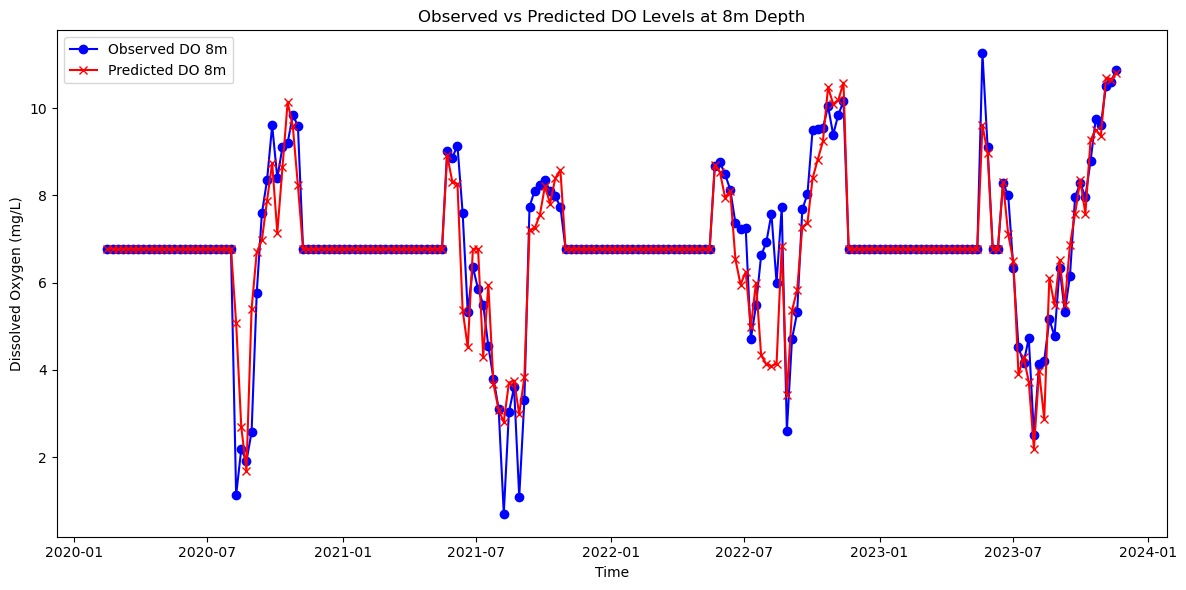

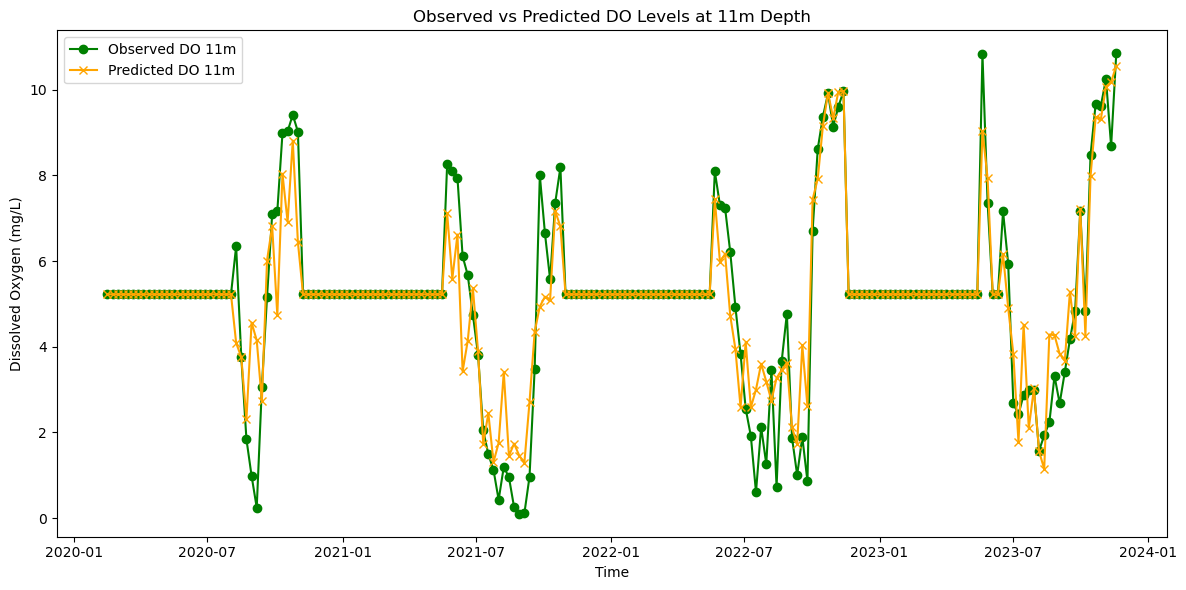

Evaluation Metrics for 'do8m':
R-squared: 0.82
Mean Absolute Error (MAE): 0.34
Mean Squared Error (MSE): 0.51
Root Mean Squared Error (RMSE): 0.72

Evaluation Metrics for 'do11m':
R-squared: 0.81
Mean Absolute Error (MAE): 0.48
Mean Squared Error (MSE): 0.84
Root Mean Squared Error (RMSE): 0.92
Peirce Skill Score (PSS) for 'do8m' with only wind speed not direction: 0.8244147157190636
Peirce Skill Score (PSS) for 'do11m' with only wind speed not direction: 0.7856472795497186


In [31]:
# Select the columns for the new dataset
selected_columns = [
    'wt2m', 'wt4m', 'wt6m', 'wt7m', 'wt9m', 'wt11m', 
    'wspd', 'do8m', 'do11m','x_date'
]

# We don't need to explicitly exclude 'x_date' as it's the index and not a column
# Create the new dataset
ml = ML[selected_columns].copy()

ml.set_index('x_date', inplace=True)

# Filter data to include only between 5/1 and 11/1 each year
# and exclude data after 11/1/2022
ml_filtered = ml[(ml.index.month >= 5) & (ml.index.month <= 11) & (ml.index < '2022-11-02')]
#Evident is the disocnitunity in the data
# Make the time series continuous
# Set frequency to daily and reindex to fill missing dates with NaNs
ml = ml.asfreq('D')
ml = ml.reindex(pd.date_range(start=ml.index.min(), end=ml.index.max(), freq='D'))

# Resample the data to get weekly averages
# 'W' stands for weekly frequency
ml_weekly = ml.resample('W').mean()

# Create an instance of KNNImputer
# n_neighbors can be adjusted based on your dataset
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputation
ml_weekly_imputed = imputer.fit_transform(ml_weekly)

# Convert the imputed data back to a DataFrame
ml_weekly_imputed_df = pd.DataFrame(ml_weekly_imputed, columns=ml_weekly.columns, index=ml_weekly.index)

# Display the first few rows of the imputed dataset
print(ml_weekly_imputed_df.head())

# Check for remaining NaNs
nan_counts_after_imputation = ml_weekly_imputed_df.isna().sum()
print("Number of NaN values in each column after KNN imputation:\n", nan_counts_after_imputation)
##########################################################################################################
# Features (excluding 'do8m' and 'do11m')
feature_columns = [col for col in ml_weekly_imputed_df.columns if col not in ['do8m', 'do11m']]
X = ml_weekly_imputed_df[feature_columns]

# Target variables
y_do8m = ml_weekly_imputed_df['do8m']
y_do11m = ml_weekly_imputed_df['do11m']
################################################################################################
#70% of the data for training and 30% for testing
# Calculate the index to split the data
split_index = int(len(ml_weekly_imputed_df) * 0.7)

# Temporal split for the features
X_train = ml_weekly_imputed_df[feature_columns][:split_index]
X_test = ml_weekly_imputed_df[feature_columns][split_index:]

# Temporal split for 'do8m'
y_train_do8m = ml_weekly_imputed_df['do8m'][:split_index]
y_test_do8m = ml_weekly_imputed_df['do8m'][split_index:]
dates_8m = y_test_do8m.index  # Test dates for 'do8m'

# Temporal split for 'do11m'
y_train_do11m = ml_weekly_imputed_df['do11m'][:split_index]
y_test_do11m = ml_weekly_imputed_df['do11m'][split_index:]
dates_11m = y_test_do11m.index  # Test dates for 'do11m'
#######################################################################################################
#Training the Random Forest Models
# Train the model for 'do8m'
rf_do8m = RandomForestRegressor(n_estimators=100, random_state=42)
rf_do8m.fit(X_train, y_train_do8m)

# Train the model for 'do11m'
rf_do11m = RandomForestRegressor(n_estimators=100, random_state=42)
rf_do11m.fit(X_train, y_train_do11m)
#################################################################################################
# Make predictions for 'do8m'
y_pred_do8m = rf_do8m.predict(X_test)

# Make predictions for 'do11m'
y_pred_do11m = rf_do11m.predict(X_test)

####################################################################################
# Plotting the results for 'do8m'
plt.figure(figsize=(12, 6))
plt.plot(dates_8m, y_test_do8m, color='blue', label='Observed DO 8m', marker='o')
plt.plot(dates_8m, y_pred_do8m, color='red', label='Predicted DO 8m', marker='x')
plt.title('Observed vs Predicted DO Levels at 8m Depth')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()

plt.tight_layout()

# Plotting the results for 'do11m'
plt.figure(figsize=(12, 6))
plt.plot(dates_11m, y_test_do11m, color='green', label='Observed DO 11m', marker='o')
plt.plot(dates_11m, y_pred_do11m, color='orange', label='Predicted DO 11m', marker='x')
plt.title('Observed vs Predicted DO Levels at 11m Depth')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()

plt.tight_layout()
plt.show()

###########################################################################################
# For 'do8m'
r2_do8m = r2_score(y_test_do8m, y_pred_do8m)
mae_do8m = mean_absolute_error(y_test_do8m, y_pred_do8m)
mse_do8m = mean_squared_error(y_test_do8m, y_pred_do8m)
rmse_do8m = mean_squared_error(y_test_do8m, y_pred_do8m, squared=False)

# For 'do11m'
r2_do11m = r2_score(y_test_do11m, y_pred_do11m)
mae_do11m = mean_absolute_error(y_test_do11m, y_pred_do11m)
mse_do11m = mean_squared_error(y_test_do11m, y_pred_do11m)
rmse_do11m = mean_squared_error(y_test_do11m, y_pred_do11m, squared=False)
print(f"Evaluation Metrics for 'do8m':")
print(f"R-squared: {r2_do8m:.2f}")
print(f"Mean Absolute Error (MAE): {mae_do8m:.2f}")
print(f"Mean Squared Error (MSE): {mse_do8m:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_do8m:.2f}\n")

print(f"Evaluation Metrics for 'do11m':")
print(f"R-squared: {r2_do11m:.2f}")
print(f"Mean Absolute Error (MAE): {mae_do11m:.2f}")
print(f"Mean Squared Error (MSE): {mse_do11m:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_do11m:.2f}")
####################################################################################
#Pierce Skill Score
#Define the Threshold and Binarize the Predicted and Actual Values
#PSS=TPR−FPR
# Define the threshold
threshold = 4

# Binarize the predicted and actual values based on the threshold
# low DO (<= 4 mg/L) is represented by 1, normal/high DO (> 4 mg/L) is represented by 0
y_test_do8m_binarized = (y_test_do8m <= threshold).astype(int)
y_pred_do8m_binarized = (y_pred_do8m <= threshold).astype(int)

y_test_do11m_binarized = (y_test_do11m <= threshold).astype(int)
y_pred_do11m_binarized = (y_pred_do11m <= threshold).astype(int)

#Calculate the Confusion Matrix, TPR, FPR, and PSS

# For 'do8m'
tn_8m, fp_8m, fn_8m, tp_8m = confusion_matrix(y_test_do8m_binarized, y_pred_do8m_binarized).ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for 'do8m'
tpr_8m = tp_8m / (tp_8m + fn_8m)
fpr_8m = fp_8m / (fp_8m + tn_8m)

# Calculate Peirce Skill Score (PSS) for 'do8m'
pss_8m = tpr_8m - fpr_8m

# For 'do11m'
tn_11m, fp_11m, fn_11m, tp_11m = confusion_matrix(y_test_do11m_binarized, y_pred_do11m_binarized).ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for 'do11m'
tpr_11m = tp_11m / (tp_11m + fn_11m)
fpr_11m = fp_11m / (fp_11m + tn_11m)

# Calculate Peirce Skill Score (PSS) for 'do11m'
pss_11m = tpr_11m - fpr_11m

print(f"Peirce Skill Score (PSS) for 'do8m' with only wind speed not direction: {pss_8m}")
print(f"Peirce Skill Score (PSS) for 'do11m' with only wind speed not direction: {pss_11m}")

                 wt2m       wt4m       wt6m       wt7m       wt9m      wt11m  \
2011-05-08  66.544773  66.299477  65.459943  63.290523  60.081757  59.597118   
2011-05-15  66.544773  66.299477  65.459943  63.290523  60.081757  59.597118   
2011-05-22  66.544773  66.299477  65.459943  63.290523  60.081757  59.597118   
2011-05-29  60.990000  60.890000  60.875000  60.835000  60.775000  59.474571   
2011-06-05  65.695714  65.215714  64.975714  64.468571  63.547143  63.240971   

                do8m     do11m  
2011-05-08  6.777864  5.224193  
2011-05-15  6.777864  5.224193  
2011-05-22  6.777864  5.224193  
2011-05-29  8.510000  8.240000  
2011-06-05  8.410000  7.771429  
Number of NaN values in each column after KNN imputation:
 wt2m     0
wt4m     0
wt6m     0
wt7m     0
wt9m     0
wt11m    0
do8m     0
do11m    0
dtype: int64


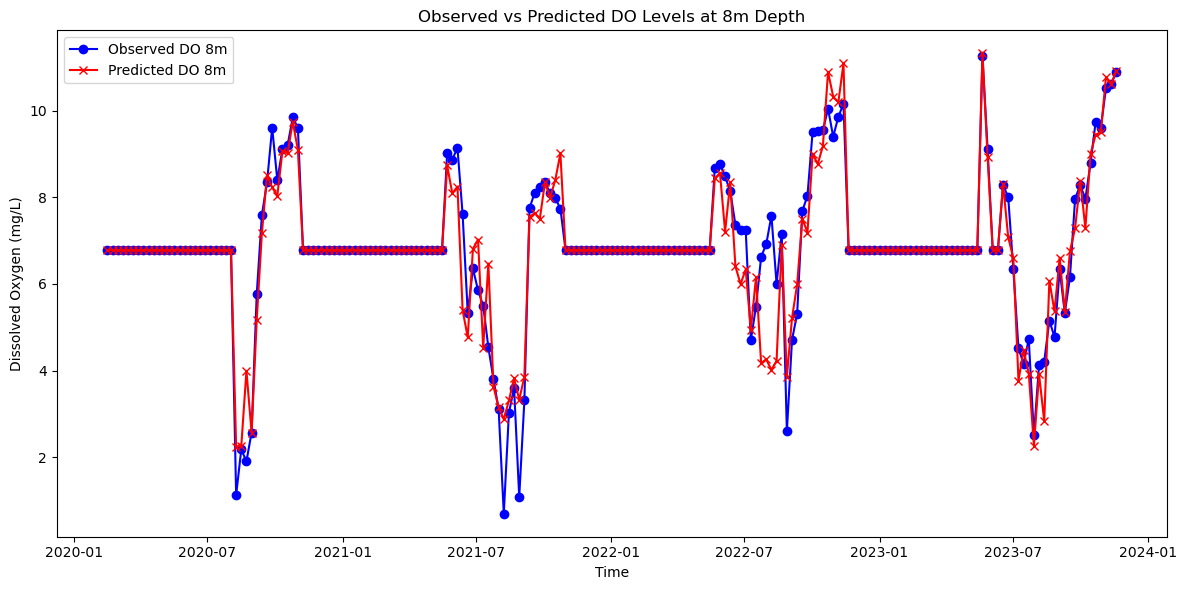

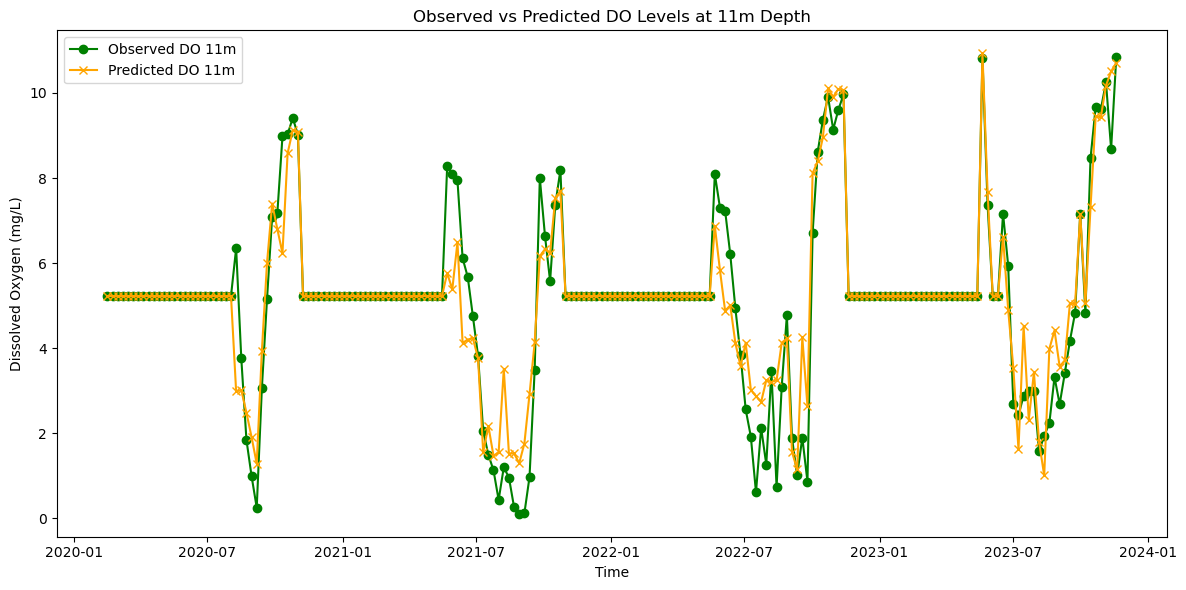

Evaluation Metrics for 'do8m':
R-squared: 0.85
Mean Absolute Error (MAE): 0.30
Mean Squared Error (MSE): 0.42
Root Mean Squared Error (RMSE): 0.65

Evaluation Metrics for 'do11m':
R-squared: 0.86
Mean Absolute Error (MAE): 0.42
Mean Squared Error (MSE): 0.66
Root Mean Squared Error (RMSE): 0.81
Peirce Skill Score (PSS) for 'do8m' without wind: 0.9782608695652174
Peirce Skill Score (PSS) for 'do11m' without wind: 0.8472482801751094


In [28]:

# Select the columns for the new dataset
selected_columns = [
    'wt2m', 'wt4m', 'wt6m', 'wt7m', 'wt9m', 'wt11m', 'do8m', 'do11m','x_date'
]
# We don't need to explicitly exclude 'x_date' as it's the index and not a column
# Create the new dataset
ml = ML[selected_columns].copy()

ml.set_index('x_date', inplace=True)

# Filter data to include only between 5/1 and 11/1 each year
# and exclude data after 11/1/2022
ml_filtered = ml[(ml.index.month >= 5) & (ml.index.month <= 11) & (ml.index < '2022-11-02')]
#Evident is the disocnitunity in the data
# Make the time series continuous
# Set frequency to daily and reindex to fill missing dates with NaNs
ml = ml.asfreq('D')
ml = ml.reindex(pd.date_range(start=ml.index.min(), end=ml.index.max(), freq='D'))

# Resample the data to get weekly averages
# 'W' stands for weekly frequency
ml_weekly = ml.resample('W').mean()

# Create an instance of KNNImputer
# n_neighbors can be adjusted based on your dataset
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN imputation
ml_weekly_imputed = imputer.fit_transform(ml_weekly)

# Convert the imputed data back to a DataFrame
ml_weekly_imputed_df = pd.DataFrame(ml_weekly_imputed, columns=ml_weekly.columns, index=ml_weekly.index)

# Display the first few rows of the imputed dataset
print(ml_weekly_imputed_df.head())

# Check for remaining NaNs
nan_counts_after_imputation = ml_weekly_imputed_df.isna().sum()
print("Number of NaN values in each column after KNN imputation:\n", nan_counts_after_imputation)
##########################################################################################################
# Features (excluding 'do8m' and 'do11m')
feature_columns = [col for col in ml_weekly_imputed_df.columns if col not in ['do8m', 'do11m']]
X = ml_weekly_imputed_df[feature_columns]

# Target variables
y_do8m = ml_weekly_imputed_df['do8m']
y_do11m = ml_weekly_imputed_df['do11m']
################################################################################################
#70% of the data for training and 30% for testing
# Calculate the index to split the data
split_index = int(len(ml_weekly_imputed_df) * 0.7)

# Temporal split for the features
X_train = ml_weekly_imputed_df[feature_columns][:split_index]
X_test = ml_weekly_imputed_df[feature_columns][split_index:]

# Temporal split for 'do8m'
y_train_do8m = ml_weekly_imputed_df['do8m'][:split_index]
y_test_do8m = ml_weekly_imputed_df['do8m'][split_index:]
dates_8m = y_test_do8m.index  # Test dates for 'do8m'

# Temporal split for 'do11m'
y_train_do11m = ml_weekly_imputed_df['do11m'][:split_index]
y_test_do11m = ml_weekly_imputed_df['do11m'][split_index:]
dates_11m = y_test_do11m.index  # Test dates for 'do11m'
#######################################################################################################
#Training the Random Forest Models
# Train the model for 'do8m'
rf_do8m = RandomForestRegressor(n_estimators=100, random_state=42)
rf_do8m.fit(X_train, y_train_do8m)

# Train the model for 'do11m'
rf_do11m = RandomForestRegressor(n_estimators=100, random_state=42)
rf_do11m.fit(X_train, y_train_do11m)
#################################################################################################
# Make predictions for 'do8m'
y_pred_do8m = rf_do8m.predict(X_test)

# Make predictions for 'do11m'
y_pred_do11m = rf_do11m.predict(X_test)

####################################################################################
# Plotting the results for 'do8m'
plt.figure(figsize=(12, 6))
plt.plot(dates_8m, y_test_do8m, color='blue', label='Observed DO 8m', marker='o')
plt.plot(dates_8m, y_pred_do8m, color='red', label='Predicted DO 8m', marker='x')
plt.title('Observed vs Predicted DO Levels at 8m Depth')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()

plt.tight_layout()

# Plotting the results for 'do11m'
plt.figure(figsize=(12, 6))
plt.plot(dates_11m, y_test_do11m, color='green', label='Observed DO 11m', marker='o')
plt.plot(dates_11m, y_pred_do11m, color='orange', label='Predicted DO 11m', marker='x')
plt.title('Observed vs Predicted DO Levels at 11m Depth')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()

plt.tight_layout()
plt.show()

###########################################################################################
# For 'do8m'
r2_do8m = r2_score(y_test_do8m, y_pred_do8m)
mae_do8m = mean_absolute_error(y_test_do8m, y_pred_do8m)
mse_do8m = mean_squared_error(y_test_do8m, y_pred_do8m)
rmse_do8m = mean_squared_error(y_test_do8m, y_pred_do8m, squared=False)

# For 'do11m'
r2_do11m = r2_score(y_test_do11m, y_pred_do11m)
mae_do11m = mean_absolute_error(y_test_do11m, y_pred_do11m)
mse_do11m = mean_squared_error(y_test_do11m, y_pred_do11m)
rmse_do11m = mean_squared_error(y_test_do11m, y_pred_do11m, squared=False)
print(f"Evaluation Metrics for 'do8m':")
print(f"R-squared: {r2_do8m:.2f}")
print(f"Mean Absolute Error (MAE): {mae_do8m:.2f}")
print(f"Mean Squared Error (MSE): {mse_do8m:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_do8m:.2f}\n")

print(f"Evaluation Metrics for 'do11m':")
print(f"R-squared: {r2_do11m:.2f}")
print(f"Mean Absolute Error (MAE): {mae_do11m:.2f}")
print(f"Mean Squared Error (MSE): {mse_do11m:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_do11m:.2f}")
####################################################################################
#Pierce Skill Score
#Define the Threshold and Binarize the Predicted and Actual Values
#PSS=TPR−FPR
# Define the threshold
threshold = 4

# Binarize the predicted and actual values based on the threshold
# low DO (<= 4 mg/L) is represented by 1, normal/high DO (> 4 mg/L) is represented by 0
y_test_do8m_binarized = (y_test_do8m <= threshold).astype(int)
y_pred_do8m_binarized = (y_pred_do8m <= threshold).astype(int)

y_test_do11m_binarized = (y_test_do11m <= threshold).astype(int)
y_pred_do11m_binarized = (y_pred_do11m <= threshold).astype(int)

#Calculate the Confusion Matrix, TPR, FPR, and PSS

# For 'do8m'
tn_8m, fp_8m, fn_8m, tp_8m = confusion_matrix(y_test_do8m_binarized, y_pred_do8m_binarized).ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for 'do8m'
tpr_8m = tp_8m / (tp_8m + fn_8m)
fpr_8m = fp_8m / (fp_8m + tn_8m)

# Calculate Peirce Skill Score (PSS) for 'do8m'
pss_8m = tpr_8m - fpr_8m

# For 'do11m'
tn_11m, fp_11m, fn_11m, tp_11m = confusion_matrix(y_test_do11m_binarized, y_pred_do11m_binarized).ravel()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for 'do11m'
tpr_11m = tp_11m / (tp_11m + fn_11m)
fpr_11m = fp_11m / (fp_11m + tn_11m)

# Calculate Peirce Skill Score (PSS) for 'do11m'
pss_11m = tpr_11m - fpr_11m

print(f"Peirce Skill Score (PSS) for 'do8m' without wind: {pss_8m}")
print(f"Peirce Skill Score (PSS) for 'do11m' without wind: {pss_11m}")